<a href="https://colab.research.google.com/github/itsalanthomas/shipping-optimization/blob/dev/src/Ecommerce_Optimization_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# load libraries
from google.colab import files
from io import StringIO
import pandas  as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# load data in with file simulation
uploaded = files.upload()
filename = 'ecommerce_shipping_cleaned.csv'

with open(filename, 'r') as file:
  csv_text = file.read()

# create df
df = pd.read_csv(StringIO(csv_text))
df


Saving ecommerce_shipping_cleaned.csv to ecommerce_shipping_cleaned (6).csv


,Id,Warehouse Block,Mode Of Shipment,Customer Care Calls,Customer Rating,Cost Of The Product,Prior Purchases,Product Importance,Gender,Discount Offered,Weight In Gms,On-Time Delivery,Net Price,Discount Ratio,Status By Mode Of Shipment
0,1,D,Flight,4,2,177,3,0,F,44,1233,1,133,0.25,0.6
1,2,F,Flight,4,5,216,2,0,M,59,3088,1,157,0.27,0.6
2,3,A,Flight,2,2,183,4,0,M,48,3374,1,135,0.26,0.6
3,4,B,Flight,3,3,176,4,1,M,10,1177,1,166,0.06,0.6
4,5,C,Flight,2,2,184,3,1,F,46,2484,1,138,0.25,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,1,F,1,1538,1,251,0.00,0.6
10995,10996,B,Ship,4,1,232,5,1,F,6,1247,0,226,0.03,0.6
10996,10997,C,Ship,5,4,242,5,0,F,4,1155,0,238,0.02,0.6
10997,10998,F,Ship,5,2,223,6,1,M,2,1210,0,221,0.01,0.6


In [54]:
# One hot encode categorical columns
categorical_cols = ['Warehouse Block', 'Mode Of Shipment', 'Gender']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [55]:
# Drop ID column and target
X = df.drop(['Id', 'On-Time Delivery'], axis=1)
y = df['On-Time Delivery']

In [56]:
# Define feature vs target variable
X = df.drop('On-Time Delivery', axis=1)
y = df['On-Time Delivery']

In [57]:
# Train, test and split model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
# Build and predict RF model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
# Predict
y_pred = rf_model.predict(X_test)

In [59]:
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.75      0.64      1312
           1       0.79      0.62      0.69      1988

    accuracy                           0.67      3300
   macro avg       0.68      0.68      0.67      3300
weighted avg       0.70      0.67      0.67      3300

[[ 982  330]
 [ 762 1226]]


In [60]:
# Hyper Parameter tuning via GridSearch
# base RF model
rf_base = RandomForestClassifier(random_state=42)

In [61]:
# Distributions
param_dist = {
    'n_estimators': randint(100, 300),         # number of trees
    'max_depth': randint(5, 20),               # tree depth
    'min_samples_leaf': randint(1, 5),         # min samples in a leaf node
    'max_features': ['sqrt', 'log2', None],    # number of features
}

In [62]:
# Random Search
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [63]:
# Fit training data
rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e96e5a0c5d0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e96e5a0ca50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e96e5a0de50>},
                   random_state=42, scoring='f1', verbose=1)

In [64]:
# best model
best_rf = rf_search.best_estimator_

In [65]:
# prediction and evaluation
y_pred_rf = best_rf.predict(X_test)

In [66]:
# Results
print('Best Hyperparameters:', rf_search.best_params_)
print('Accuracy:', round(accuracy_score(y_test, y_pred_rf), 2))
print('\nClassification Report:\n', classification_report(y_test, y_pred_rf))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))

Best Hyperparameters: {'max_depth': 19, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 180}
Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.76      0.64      1312
           1       0.79      0.61      0.69      1988

    accuracy                           0.67      3300
   macro avg       0.68      0.68      0.66      3300
weighted avg       0.70      0.67      0.67      3300

Confusion Matrix:
 [[ 993  319]
 [ 782 1206]]


AUC-ROC (Random Forest): 0.74


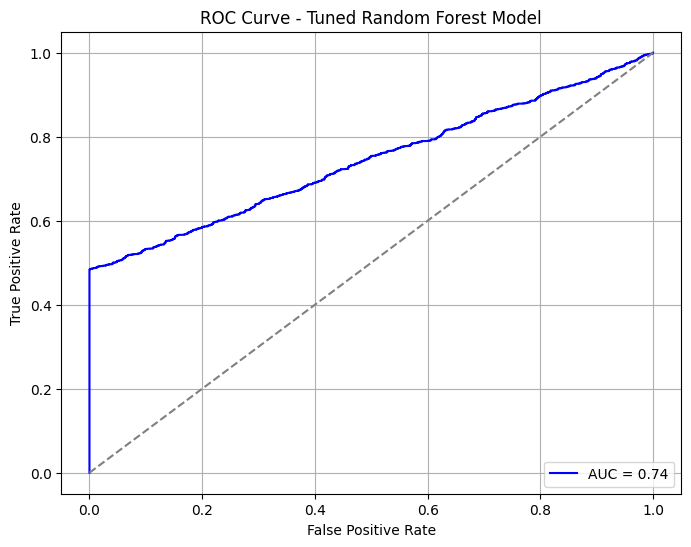

In [70]:
# ROC Curve
# Get predicted probabilities for class 1 (late delivery)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC (Random Forest): {auc_rf:.2f}")

# Create ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()